# Prediction of Cycle Life of Batteries
Notebook created by: Elahe Talaie (@ <a href = "https://www.eng.mcmaster.ca/people/faculty/seshasai-srinivasan-peng">Dr. Srinivasan</a> research group at McMaster University)

# 1. Introduction

This notebook presents a simple process for the prediction of the useful life of Li-ion batteries based on their early cycle life performance. The input features are derived from the measurement of voltage, current, time, and temperature of the batteries during the charge and discharge. 

The dataset used in this project is obtained from a publicly available <a href = "https://data.matr.io/1/projects/5c48dd2bc625d700019f3204">repository</a> [1]. The data is collected from the cycling of 120 identical commercial LFP/graphite Li-ion batteries, using 72 different fast-charging conditions but identical discharging conditions. The cycle lives of the batteries ranged from 335 to 2237 cycles, with cycle life (or equivalently, end of life) defined as the number of cycles until 80% of nominal capacity.

In the pre-processing section, the input features for the model are described, and the functions for the processing of the raw data files to extract the features are presented. In the model section, a ridge regression model is trained to predict the end of life of the batteries based on the features derived from the first 100 cycles. 

[1] Severson et al. Data-driven prediction of battery cycle life before capacity degradation. Nature Energy volume 4, pages 383–391 (2019).

# 2. Pre-processing

### Features description

The 6 different features used in this model are as described below:

#### 1. "Variance_DeltaQ":

$\Delta Q(V)=Q_{100}(V)-Q_{10}(V),\,\Delta Q(V)\,\in\,\mathbb{R}^{1000}$
<br>$Variance\_DeltaQ=log(\mid \frac{1}{999}\sum_{i=1}^{1000} (\Delta Q(V) - \overline {\Delta Q}(V))^2 \mid)$

$\;\;\;\;\;\;$
$\;\;\;\;\;\;$

#### 2. "Discharge_Capacity":
##### Discharge Capacity at cycle 2

$\;\;\;\;\;\;$

#### 3. "Capacity_Fade":
##### The slope of the linear fit to the capacity fade curve (discharge capacity vs cycle number) from cycle 2 to cycle 100

$\;\;\;\;\;\;$
$\;\;\;\;\;\;$

#### 4. "Energy_Fade":
##### The logarithmic transformation of theslope of the linear fit to the energy fade curve (discharge energy vs cycle number) from cycle 2 to cycle 100 

$\;\;\;\;\;\;$
$\;\;\;\;\;\;$

#### 5. "Charge_Time": Average charging time over 5 cycles, from cycle 2 to cycle 6  


$Charge\_Time = \frac{1}{5} \sum_{i=2}^{6} ChargeTime_{i}$

$\;\;\;\;\;\;$
$\;\;\;\;\;\;$

#### 6. "Temperature_Integral": Integral of temperature over time, cycles 2 to 100


$Temperature\_Integral = \int_{t_2}^{t_{100}} T(t)dt$

$\;\;\;\;\;\;$
$\;\;\;\;\;\;$

### Calculating the features

This functions below are aimed to process the raw battery data csv files in the  <a href = "https://data.matr.io/1/projects/5c48dd2bc625d700019f3204">repository</a>.

In [1]:
#Import the libraries
import os
import pandas as pd
import numpy as np
from scipy import interpolate
import math
from sklearn.linear_model import LinearRegression
import statistics
from scipy import integrate
from tqdm import tqdm

In [2]:
# Define a function to get measured parameters of the cell for each cycle
def Cyc_Param(df):
    """
    Gets the summary measurement data for each cycle of the cell from the raw data file
    
    Arguments:
    df-- dataframe containing the raw cycling data of the cell
    
    Returns:
    df_cycles -- dataframe containing the summary data for each cycle
    """
    df_cycles = df.loc[((df['Charge_Capacity']*df['Discharge_Capacity'])>0.1)&(df['Current']==0)]
    df_cycles = df_cycles.drop_duplicates(subset='Cycle_Index')
    return(df_cycles)

In [3]:
def Get_Cycle(df, Cycle_Index):
    """
    Gets the summary measurement data of a given cycle index
    
    Arguments:
    df-- dataframe containing the summary data of all the cycles (output of the Cyc_Param function)
    Cycle_Index-- cycle index
    
    Returns:
    df_Cycle_Index -- dataframe containing one row of measured data for each cycle
    """
    df_Cycle_Index = df.loc[df['Cycle_Index']==Cycle_Index]
    return df_Cycle_Index

In [4]:
def Standard_Curve(df, Cycle_Index):
    """
    Standardizes the discharge capacity vs. voltage curve by linear interpolation of curves to standard 1000 data points within the voltage range of 3.5 to 2.0 V.
    
    Arguments:
    df-- dataframe containing the summary data of all the cycles (output of the Cyc_Param function)
    Cycle_Index-- cycle index
    
    Returns:
    Q_new -- standardized discharge capacity vs. voltage curve
    """
    #Get slices of the dataframe corresponding to discharge of a given Cycle index
    Discharge = Get_Cycle(df, Cycle_Index).loc[(df['Current']<-3.5)&(df['Voltage']>2.05)]
    #Get the discharge capacity and voltage data points corresponding to that given cycle.
    Q_Values = Discharge['Discharge_Capacity'].values
    V_Values= Discharge['Voltage'].values
    #Standardize the discharge capacity vs voltage curves by linear interpolation of curves to standard 1000 data points within the voltage range of 3.5 to 2.0 V.
    V_new = np.arange(3.5, 2.0, -0.0015)
    interp1D_fn = interpolate.interp1d(V_Values, Q_Values, fill_value='extrapolate')
    Q_new = interp1D_fn(V_new)
    return(Q_new)
        

In [5]:
def FitCapacityFade(df_cycles, start_cycle_index, stop_cycle_index):
    """
    Calculates the "Slope" and "Intercept" from linear regression to the capacity fade curve, from start_cycle_index to stop_cycle_index
    
    Arguments:
    df_cycles -- dataframe containing the summary data for each cycle
    start_cycle_index
    stop_cycle_index
    
    Returns:
    Slope-- the slope of the line fitted to the capacity fade curve
    Intercept-- the intercept of the line fitted to the capacity fade curve
    """
    X=df_cycles[['Cycle_Index']][start_cycle_index-1: stop_cycle_index]
    y = df_cycles[['Discharge_Capacity']][start_cycle_index-1: stop_cycle_index]
    lre = LinearRegression()
    lre.fit(X,y)
    Y_pred=lre.predict(X)
    Intercept = np.ndarray.item(lre.intercept_)
    Slope = np.ndarray.item(lre.coef_)
    return(Slope, Intercept)              

In [6]:
def FitEnergyFade(df_cycles, start_cycle_index, stop_cycle_index):
    """
    Calculates the "Slope" and "Intercept" from linear regression to the energy fade curve, from start_cycle_index to stop_cycle_index
    
    Arguments:
    df_cycles -- dataframe containing the summary data for each cycle
    start_cycle_index
    stop_cycle_index
    
    Returns:
    Slope-- the slope of the line fitted to the energy fade curve
    Intercept-- the intercept of the line fitted to the energy fade curve
    """
    X=df_cycles[['Cycle_Index']][start_cycle_index-1: stop_cycle_index]
    y = df_cycles[['Discharge_Energy']][start_cycle_index-1: stop_cycle_index]
    lre = LinearRegression()
    lre.fit(X,y)
    Y_pred=lre.predict(X)
    Intercept = np.ndarray.item(lre.intercept_)
    Slope = np.ndarray.item(lre.coef_)
    return(Slope, Intercept) 

In [7]:
 # Define a function that calculates the charging time of a given cycle index
def ChargeTime(df, Cycle_Index):
    """
    Calculates the charging time of a given cycle index
    
    Arguments:
    df -- dataframe containing the raw data of the cell
    cycle_index
        
    Returns:
    ChargeTime-- the charging time 
    """
    df_CycleIndex = df.loc[df['Cycle_Index']==Cycle_Index]
    ChargeTime = max(df_CycleIndex['Test_Time'].loc[(df_CycleIndex['Step_Index']>4)&(df_CycleIndex['Step_Index']<10)])-min(df_CycleIndex['Test_Time'].loc[(df_CycleIndex['Step_Index']>4)&(df_CycleIndex['Step_Index']<10)])
    return ChargeTime

In [8]:
#Calculate integral of temperature over time, from start_cycle_index to stop_cycle_index
def Temperature_integral(df, start_cycle_index, stop_cycle_index):
    """
    Calculates the integral of temperature over time, from start_cycle_index to stop_cycle_index
    
    Arguments:
    df -- dataframe containing the raw data of the cell
    start_cycle_index
    stop_cycle_index
        
    Returns:
    Temperature_Integral-- the integral of temperature over time 
    """
    # Slice the dataframe from start_cycle_index to stop_cycle_index
    df_Cycles = df.loc[(df['Cycle_Index']>start_cycle_index-1)&(df['Cycle_Index']<stop_cycle_index+1)]

    # Calculate the integral of temperature over time
    Temperature_Integral = np.trapz(df_Cycles['Temperature'], df_Cycles['DateTime'])  
    return Temperature_Integral

In [9]:
def Cycle_life(df_cycles):
    """
    Returns the target paremeter (cycle life). 
    
    Arguments: 
    df_cycles -- dataframe containing the summary data for each cycle
           
    Returns: 
    Cycle_Life: target parameter
    """
    #To deal with possible noise
    try:
        EndOfLifeCycles = (df_cycles['Cycle_Index'].loc[df_cycles['Discharge_Capacity']<=0.88]).to_list()
        Cycle_i0 = df_cycles['Discharge_Capacity'].loc[df_cycles['Cycle_Index']==EndOfLifeCycles[0]].to_list()[0]
        if len(EndOfLifeCycles) == 1:
            Cycle_Life = int(EndOfLifeCycles[0])
        else:
            Cycle_i1 = df_cycles['Discharge_Capacity'].loc[df_cycles['Cycle_Index']==EndOfLifeCycles[1]].to_list()[0]
            if Cycle_i0 > Cycle_i1:
                Cycle_Life = int(EndOfLifeCycles[0])
            else:
                Cycle_Life = int(EndOfLifeCycles[1])  
    #To mark the files that do not contain the whole data on cycle life     
    except:
        Cycle_Life = 1
    return Cycle_Life

In [10]:
def battery_data_processing():
    
    # Start a dataframe that will contain the discharge capacity of each cycle for each cell
    cycle_index = np.array(range(1, 2501))
    df_Discharge_Capacity=pd.DataFrame({'cycle_Index': cycle_index})
    index=0

    #Start a dataframe that will contain the features of each cell (corresponding to each file)
    df_Features=pd.DataFrame(columns=['ID', 'Variance_DeltaQ', 'Discharge_Capacity', 'Capacity_Fade', 'Energy_Fade','Charge_Time', 'Temperature_Integral',
            'Minimum_Internal_Resistance', 'Cycle_Life'])

  
    # Find and read all the .csv files in the directory
    WorkingDirectory = os.getcwd()
    for file in tqdm(os.scandir(WorkingDirectory)):

        # Process every .csvfile in the directory
        if os.path.splitext(file)[1] == '.csv':
            index = index + 1

            File_Name = os.path.splitext(file)[0].split('\\')[-1]

            # Convert the cycling data into a dataframe
            df = pd.read_csv(file)

            #Drop the data corresponding to Cycle_Index=0 (Too many data points and the data will not be used in the processing)
            to_drop_index = df.loc[df['Cycle_Index']==0].index
            df = df.drop(index = to_drop_index)

            # Define a new dataframe containing information about each Cycle_Index
            df_cycles = Cyc_Param(df)

            # Add the discharge capacity of all the cycles of the cell into the df_Discharge_Capacity dataframe 
            Values = df_cycles.Discharge_Capacity.tolist()
            Values.extend([0]*(2500-len(df_cycles.Discharge_Capacity.tolist()))) #Add zeros for to match the size of the dataframe
            df_Discharge_Capacity.insert(index, File_Name, Values)

            # Define and get the features (For the defenition and description of the features see the markdowns cells below.)

            # The features corresponding to the voltage profile: Get the difference of discharge capacity vs voltage curves of cycles 10 and 100 from standardized curves, the minimum value and the variance
            DeltaQ_V_interp1D = Standard_Curve(df, 100) -Standard_Curve(df, 10)
            DeltaQ_V_interp1D = DeltaQ_V_interp1D[~np.isnan(DeltaQ_V_interp1D)]
            #min_DeltaQ = math.log10(np.absolute(np.amin(DeltaQ_V_interp1D)))
            Variance_DeltaQ_10_100 = math.log10(np.absolute(np.var(DeltaQ_V_interp1D, ddof=1)))

            #Discharge capacity fade and energy fade curves features
            Discharge_Capacity_2 =np.ndarray.item(df_cycles['Discharge_Capacity'].loc[df['Cycle_Index']==2].values)
            Slope_Capacity_20_100 = FitCapacityFade(df_cycles, 20, 100)[0]
            Slope_Energy_20_100 = FitEnergyFade(df_cycles, 20, 100)[0]
            Slope_Energy_20_100_log = np.log(-FitEnergyFade(df_cycles, 20, 100)[0])

            #Average charging time over 5 cycles, from cycle 2 to cycle 6
            #List of the charging time of given cycles (here, cycle 2 to 6)
            ChargeTime_List = [ChargeTime(df, cycle_index) for cycle_index in range(2,7)]
            # Calculate the average charging time (here, from cycle 2 to 6)
            Average_Charge_Time = statistics.mean(ChargeTime_List)
            
            # Tempreture integral over cycles 2 to 100
            Temperature_Integral_2_100 = Temperature_integral(df, 2, 100)

            #Calculate minimum internal resistance from cycle 2 for cycle 100 (excluding zero values beacause they are not measurement points but filling NANs)
            Minimum_Internal_Resistance=min(df['Internal_Resistance'].loc[((df['Cycle_Index']>1)&(df['Cycle_Index']<101))&df['Internal_Resistance']!=0])

            #Calculate internal resistance difference between cycle 100 and cycle 2
            #Internal_Resistance=np.ndarray.item((df_cycles['Internal_Resistance'].loc[(df_cycles['Cycle_Index']==100.0)].values)-(df_cycles['Internal_Resistance'].loc[(df_cycles['Cycle_Index']==2.0)].values))

            #Calculate target paramater: Cycle Life
            #To deal with possible noise
            Cycle_Life = Cycle_life(df_cycles)

            #Add the features of the cell into the df_Features dataframe
            Features_List=[File_Name, Variance_DeltaQ_10_100, Discharge_Capacity_2, Slope_Capacity_20_100, Slope_Energy_20_100_log, Average_Charge_Time, Temperature_Integral_2_100,
            Minimum_Internal_Resistance, Cycle_Life]

            df_Features.loc[len(df_Features)] = Features_List

    #Save the processed data into the report file  

    #for r in dataframe_to_rows(df_Discharge_Capacity, index=False, header=True):
        #ws1.append(r)        


    #for r in dataframe_to_rows(df_Features, index=False, header=True):
        #ws2.append(r)
    
    df_Discharge_Capacity.to_csv('Discharge_Capacity.csv', index=False)
    df_Features.to_csv('Features.csv', index=False)
    
    return None

In [11]:
battery_data_processing()

13it [00:43,  3.16s/it]C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:605: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
138it [04:22,  1.90s/it]


### Visualization

Text(0, 0.5, 'log_Cycle life')

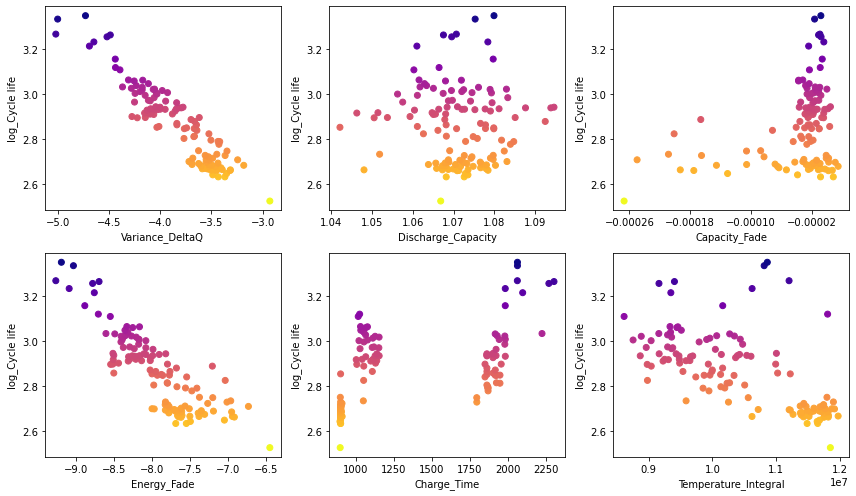

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

rcParams.update({'figure.autolayout': True})
data = pd.read_csv('Features_corrected.csv')
data['log_Cycle life'] = np.log10(data['Cycle_Life'])
data_sorted = data.sort_values(by=['Cycle_Life'])


fig, axs = plt.subplots(2, 3, figsize=(12,7))

axs[0, 0].scatter(x = data_sorted['Variance_DeltaQ'], y=data_sorted['log_Cycle life'], c = data_sorted['log_Cycle life'], cmap = 'plasma_r')
axs[0, 0].set_xlabel('Variance_DeltaQ')
axs[0, 0].set_ylabel('log_Cycle life')

axs[0, 1].scatter(x = data_sorted['Discharge_Capacity'], y=data_sorted['log_Cycle life'],  c = data_sorted['log_Cycle life'], cmap = 'plasma_r')
axs[0, 1].set_xlabel('Discharge_Capacity')
axs[0, 1].set_ylabel('log_Cycle life')

axs[0, 2].scatter(x = data_sorted['Capacity_Fade'], y=data_sorted['log_Cycle life'],  c = data_sorted['log_Cycle life'], cmap = 'plasma_r')
axs[0, 2].set_xlabel('Capacity_Fade')
axs[0, 2].set_ylabel('log_Cycle life')
axs[0, 2].set_xticks([-0.00026, -0.00018, -0.00010, -0.00002])

axs[1, 0].scatter(x = data_sorted['Energy_Fade'], y=data_sorted['log_Cycle life'],  c = data_sorted['log_Cycle life'], cmap = 'plasma_r')
axs[1, 0].set_xlabel('Energy_Fade')
axs[1, 0].set_ylabel('log_Cycle life')

axs[1, 1].scatter(x = data_sorted['Charge_Time'], y=data_sorted['log_Cycle life'],  c = data_sorted['log_Cycle life'], cmap = 'plasma_r')
axs[1, 1].set_xlabel('Charge_Time')
axs[1, 1].set_ylabel('log_Cycle life')

axs[1, 2].scatter(x = data_sorted['Temperature_Integral'], y=data_sorted['log_Cycle life'],  c = data_sorted['log_Cycle life'], cmap = 'plasma_r')
axs[1, 2].set_xlabel('Temperature_Integral')
axs[1, 2].set_ylabel('log_Cycle life')


#plt.savefig('Target vs Feature.png', dpi=300)

The graphs above show the relationship between the cycle life of the batteries (in logarithmic scale) versus each feature used in the model. 

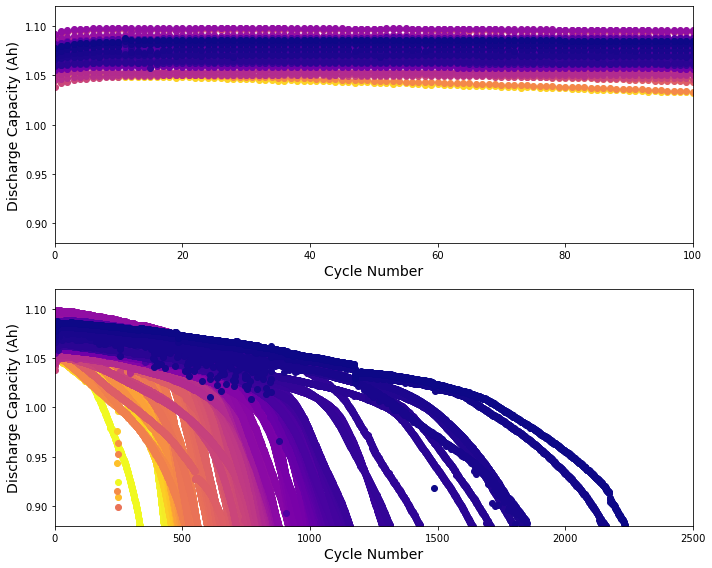

In [7]:
cycle_life = pd.read_csv('Discharge_Capacity_Corrected.csv')
cycle_life = cycle_life.replace(to_replace = 0.000000, value=np.nan)
cycle_life_dict = {}

for column in cycle_life.columns[1:]:
    cycle_life_dict[column] = len(cycle_life[column].dropna().to_list())
    
import operator
cycle_life_dict = dict(sorted(cycle_life_dict.items(), key=operator.itemgetter(1)))
sorted_columns = list(cycle_life_dict.keys())

cycle_life  = cycle_life.reindex(columns=sorted_columns)

from matplotlib import cm
cmap = cm.get_cmap('plasma_r', 120)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))

ax1.set_xlabel('Cycle Number', fontsize=14)
ax1.set_ylabel('Discharge Capacity (Ah)', fontsize=14)
ax1.set_xlim(0, 100)
ax1.set_ylim([0.88, 1.12])



ax2.set_xlabel('Cycle Number', fontsize=14)
ax2.set_ylabel('Discharge Capacity (Ah)', fontsize=14)   
ax2.set_xlim(0, 2500)
ax2.set_ylim(0.88, 1.12)


for i in range(0, 120):
    ax1.scatter(x = cycle_life.iloc[:, i].index, y=cycle_life.iloc[:, i], color = cmap(i))
    ax2.scatter(x = cycle_life.iloc[:, i].index, y=cycle_life.iloc[:, i], color = cmap(i))

The figure above shows the excellent capacity retention of the batteries over the first 100 cycles. The model presented below predicts the cycle life of the batteries based on the measurement of voltage, current, time, and temperature of the batteries during the charge and discharge over the first 100 cycles, before the degradation starts!

# 3. Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 

In [8]:
data.describe()

,Variance_DeltaQ,Discharge_Capacity,Capacity_Fade,Energy_Fade,Charge_Time,Temperature_Integral,Cycle_Life,log_Cycle life
count,120.000000,120.000000,120.000000,120.000000,120.000000,1.200000e+02,120.000000,120.000000
mean,-3.843314,1.071238,-0.000036,-7.937643,1342.159625,1.043162e+07,798.866667,2.866169
std,0.386744,0.009202,0.000052,0.525811,477.127899,9.815091e+05,362.587293,0.172319
min,-5.021867,1.042137,-0.000267,-9.259043,896.355080,8.617003e+06,335.000000,2.525045
25%,-4.103141,1.066751,-0.000033,-8.306994,901.038310,9.506257e+06,499.000000,2.698101
50%,-3.773213,1.071627,-0.000021,-7.959840,1088.201210,1.030396e+07,736.500000,2.867161
75%,-3.524707,1.077833,-0.000011,-7.618119,1869.011545,1.143038e+07,936.250000,2.971391
max,-2.929050,1.094639,0.000014,-6.455960,2301.904100,1.196801e+07,2237.000000,3.349666


In [9]:
features = data[['Variance_DeltaQ', 'Discharge_Capacity', 'Capacity_Fade','Energy_Fade', 'Charge_Time', 'Temperature_Integral']]

# Convert to numpy array
X = features.to_numpy()
y = data['log_Cycle life'].to_numpy()

In [10]:
def ridge_regression_model(X,y):
    # Train/Test split
    X_train_Original, X_test_Original, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=187)
    # Standardization
    X_train = preprocessing.StandardScaler().fit(X_train_Original).transform(X_train_Original)
    X_test = preprocessing.StandardScaler().fit(X_train_Original).transform(X_test_Original)
    #Model
    model = RidgeCV(cv=5, alphas=np.logspace(-4, 2, 500)).fit(X_train, y_train)
    #Predictions
    pred_train= model.predict(X_train)
    pred_train_linear = np.power(10, pred_train)
    pred_test = model.predict(X_test)
    pred_test_linear = np.power(10, pred_test)
    # Model metrics
    y_train_linear = np.power(10, y_train)
    y_test_linear = np.power(10, y_test)
    train_r2 = round(metrics.r2_score(y_train_linear, pred_train_linear),2)
    test_r2 = round(metrics.r2_score(y_test_linear, pred_test_linear),2)
    train_MSE = int(mean_squared_error(y_train_linear, pred_train_linear, squared=False))
    test_MSE = int(mean_squared_error(y_test_linear, pred_test_linear, squared=False))
    train_MAPE = round(mean_absolute_percentage_error(y_train_linear, pred_train_linear),2)
    test_MAPE = round(mean_absolute_percentage_error(y_test_linear, pred_test_linear),2)
    print("alpha: "+ str(model.alpha_))
    model_metrics = pd.DataFrame([[train_MSE, train_MAPE, train_r2], [test_MSE, test_MAPE, test_r2]], index=['train set', 'test set'], columns = ['RMSE', 'MAPE', 'R2_Score'])
    print(model_metrics)
    #Visualization
    from matplotlib import rcParams
    rcParams.update({'figure.autolayout': True})
    plt.figure(figsize=(5.5,5))
    plt.scatter(y_train_linear,  pred_train_linear, marker="o", c='blue', label = 'train')
    plt.scatter(y_test_linear,  pred_test_linear, marker="o", c='magenta', label = 'test')
    plt.plot(range(50,2500), range(50,2500), c='grey')
    plt.xlim(50,2500)
    plt.ylim(50,2500)
    plt.xlabel('Observed Cycle Life', fontsize=14)
    plt.ylabel('Predicted Cycle Life', fontsize=14)

    plt.legend()
    return None

alpha: 1.1916598430985588
           RMSE  MAPE  R2_Score
train set    90  6.13      0.94
test set     96  8.53      0.89


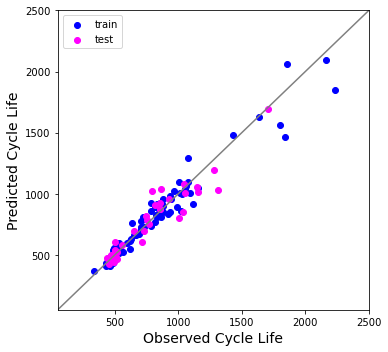

In [11]:
ridge_regression_model(X,y)


| Data Set       | RMSE    | MAPE     | R2 Score |
|----------------|---------|----------|----------|
| Train Set      | 90      | 6.13     | 0.94     |
| Test Set       | 96      | 8.53     | 0.89     |
